# Convolution Neural Network

1. Train
2. Evaluate
3. Visualize Accuracy & Lost
4. Re-evaluate Model
5. Make Predictions on the Test Set
6. Visualize classification report


In [1]:
## Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
import pandas as pd
from PIL import Image 
from PIL.ImageDraw import Draw

In [2]:
# Define Classes
classes = ['Transformer','No-Transformer']

In [3]:
# Read in Training Data and specify image directory location in system
TRAINING_CSV_FILE = 'Data/training_data2.csv'
TRAINING_IMAGE_DIR = 'Images/Training'

training_image_records = pd.read_csv(TRAINING_CSV_FILE)

train_image_path = TRAINING_IMAGE_DIR

# Initiate variables / arrays
train_images = []
train_targets = []
train_labels = []

# Iterrate through rows in the csv file
for index, row in training_image_records.iterrows():
    
    # Define a row to include the following headers from the csv
    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row
    # Specify training image path (Create string) - joining the filename in csv and the path
    train_image_fullpath = os.path.join(train_image_path, filename)
    # Load the image
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    # Create an array of the image
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    
    # Define xmin, ymin, xmax, and ymax
    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)
    
    # Append this information in their respective arrays initiated for the 'For' loop
    train_images.append(train_img_arr)
    train_targets.append((xmin, ymin, xmax, ymax))
    train_labels.append(classes.index(class_name))

In [4]:
# Repeat process as described above but with TEST CSV and images
TEST_CSV_FILE = 'Data/test_data2.csv'
TEST_IMAGE_DIR = 'Images/Test'

test_image_records = pd.read_csv(TEST_CSV_FILE)

test_image_path = TEST_IMAGE_DIR

test_images = []
test_targets = []
test_labels = []

for index, row in test_image_records.iterrows():

    (filename, width, height, class_name, xmin, ymin, xmax, ymax) = row

    test_image_fullpath = os.path.join(test_image_path, filename)
    test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=(height, width))
    test_img_arr = keras.preprocessing.image.img_to_array(test_img)


    xmin = round(xmin/ width, 2)
    ymin = round(ymin/ height, 2)
    xmax = round(xmax/ width, 2)
    ymax = round(ymax/ height, 2)

    test_images.append(test_img_arr)
    test_targets.append((xmin, ymin, xmax, ymax))
    test_labels.append(classes.index(class_name))

In [5]:
# Redefine appended arraya to np.arrays
train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_targets = np.array(test_targets)
test_labels = np.array(test_labels)

In [6]:
# Specifying width and height of images & number of classes in this classification
width = 518
height = 388
num_classes = 2


In [7]:
# Specified convolution layers
#create the common input layer
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape)

#create the base layers
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)

2021-12-07 20:25:53.729618: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
#create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch)  

In [9]:
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [10]:
model = tf.keras.Model(input_layer,
           outputs=[classifier_branch,locator_branch])

In [11]:
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
   "bb_head":tf.keras.losses.MSE}

In [12]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [13]:
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}
testTargets = {
    "cl_head": test_labels,
    "bb_head": test_targets
}

In [14]:
training_epochs = 5

history = model.fit(train_images, trainTargets,
            validation_data=(test_images, testTargets),
             batch_size=4,
             epochs=training_epochs,
             shuffle=True,
             verbose=1)

Epoch 1/5
100/100 [==============================] - 53s 522ms/step - loss: 1.2168 - cl_head_loss: 1.1172 - bb_head_loss: 0.0996 - cl_head_accuracy: 0.5175 - bb_head_accuracy: 0.2850 - val_loss: 0.7476 - val_cl_head_loss: 0.6735 - val_bb_head_loss: 0.0741 - val_cl_head_accuracy: 0.6000 - val_bb_head_accuracy: 0.0600
Epoch 2/5
100/100 [==============================] - 51s 508ms/step - loss: 0.7664 - cl_head_loss: 0.6827 - bb_head_loss: 0.0837 - cl_head_accuracy: 0.6625 - bb_head_accuracy: 0.3100 - val_loss: 0.8085 - val_cl_head_loss: 0.7349 - val_bb_head_loss: 0.0736 - val_cl_head_accuracy: 0.2500 - val_bb_head_accuracy: 0.1600
Epoch 3/5
100/100 [==============================] - 51s 508ms/step - loss: 0.5895 - cl_head_loss: 0.5293 - bb_head_loss: 0.0602 - cl_head_accuracy: 0.7225 - bb_head_accuracy: 0.4275 - val_loss: 0.8225 - val_cl_head_loss: 0.7486 - val_bb_head_loss: 0.0738 - val_cl_head_accuracy: 0.4400 - val_bb_head_accuracy: 0.0900
Epoch 4/5
100/100 [===========================

In [16]:
score = model.fit(test_images, testTargets,batch_size=4)

25/25 [==============================] - 13s 506ms/step - loss: 0.5692 - cl_head_loss: 0.5192 - bb_head_loss: 0.0500 - cl_head_accuracy: 0.7800 - bb_head_accuracy: 0.1000


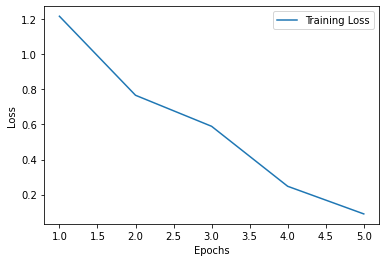

<function matplotlib.pyplot.legend(*args, **kwargs)>

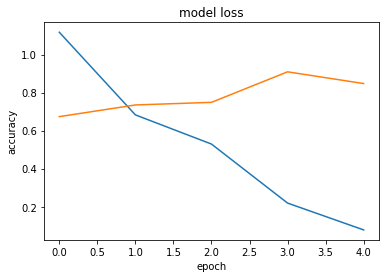

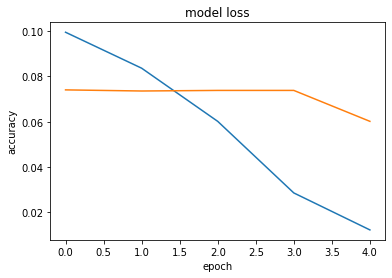

In [25]:
loss_values = history.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure()
plt.plot(history.history['cl_head_loss'])
plt.plot(history.history['val_cl_head_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend

plt.figure()
plt.plot(history.history['bb_head_loss'])
plt.plot(history.history['val_bb_head_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend


In [20]:
print(history.history)

{'loss': [1.2168086767196655, 0.7664234638214111, 0.5894597768783569, 0.2475433200597763, 0.0900595560669899], 'cl_head_loss': [1.117234706878662, 0.6827499866485596, 0.529301643371582, 0.21904441714286804, 0.07791479676961899], 'bb_head_loss': [0.09957370162010193, 0.08367351442575455, 0.06015824154019356, 0.028498906642198563, 0.012144751846790314], 'cl_head_accuracy': [0.5174999833106995, 0.6625000238418579, 0.7225000262260437, 0.9200000166893005, 0.9750000238418579], 'bb_head_accuracy': [0.2849999964237213, 0.3100000023841858, 0.42750000953674316, 0.4375, 0.5575000047683716], 'val_loss': [0.7476261854171753, 0.8084973692893982, 0.8224798440933228, 0.9829604625701904, 0.9077063202857971], 'val_cl_head_loss': [0.6735454797744751, 0.7349112629890442, 0.7486351728439331, 0.909115731716156, 0.8475409150123596], 'val_bb_head_loss': [0.07408079504966736, 0.0735861212015152, 0.07384457439184189, 0.07384466379880905, 0.06016552075743675], 'val_cl_head_accuracy': [0.6000000238418579, 0.25, 0